## Importing all required libraries

In [19]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt

## Unzipping the dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/fooddata/train_images.zip
!unzip /content/drive/MyDrive/fooddata/test_images.zip


## Defining custom dataset

In [21]:
class CustomData(Dataset):
    def __init__(self,transforms, path, imglist, train=True):
        self.path = path
        self.transforms = transforms
        self.imglist = imglist
        self.train = train
    
    def __len__(self):
        return self.imglist.shape[0]

    def __getitem__(self,idx):
        imgname = self.imglist.iloc[idx]['ImageId']
        if self.train : label = self.imglist.iloc[idx]['ClassName']
        img = cv2.imread(os.path.join(self.path,imgname))
        img = cv2.resize(img,(128,128))
        if self.transforms : img = self.transforms(img)
        result = {}
        result['img'] = img
        if self.train: result['label'] = label
        return result



## Encoding labels for training

In [22]:
train = pd.read_csv('/content/drive/MyDrive/fooddata/train.csv')
le = preprocessing.LabelEncoder()
targets = le.fit_transform(train['ClassName'])
ntrain = train
ntrain['ClassName'] = targets

## Basic Neural Network

#### In this we have 3 convolutional layers with 16,32,64 layered outputs respectively . We will make changes in this basic network and observe how outputs vary for each change and try to derive some conclusions

In [23]:
class BasicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(61504, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

## 1. Batch Normalization

#### Batch normalization is a technique for training deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

#### By adding Batch Normalization we reduce the internal covariate shift and instability in distributions of layer activations in Deeper networks can reduce the effect of overfitting and works well with generalization data.

In [24]:
class BnormNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features = 16),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features = 32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features = 64),
        )
        self.classifier = nn.Sequential(
            nn.Linear(61504, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

## 2. Adding more layers
#### Increasing the number of layers provides a short-cut to increasing the capacity of the model with fewer resources.By adding more hidden layers / more neurons per layer you add more parameters to the model. For a small dataset this tends to overfit the training data .

In [7]:
class NewLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(61504, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

## 3. Dropout
#### Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

#### During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer. 

#### Dropout helps in not letting the network learn the statistical noise in the training dataset

In [8]:
class DropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(61504, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

## Different activation functions
#### Softmax activation is used at the output layer to give a probability distribution of the classes. Sigmoid activation is used for binary classification. It is a soft flavor of the max function where instead of selecting only one class having maximum value, it assigns the maximal element the largest portion of the probability distribution, and other smaller elements getting some part of the distribution.

#### We can also use KL divergence loss function. It is a measure of how one probability distribution is different from a second. It is also known as relative cross entropy loss.

#### With KL divergence, we could have used the Softplus, Softmin, etc. activation functions at the end. But I didn’t find any suitable article suggesting to use such functions for classification problem.

#### Also in Keras, there SparseCrossCategorical activation function which could have been used.
#### In PyTorch, we have LogSoftmax which is defined as taking the log of softmax: log(exp(x_i)/exp(x).sum())

In [40]:
class SMActNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(61504, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

        

## Different Pooling Techniques

#### Pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

#### The pooling layer summarises the features present in a region of the feature map generated by a convolution layer. So, further operations are performed on summarised features instead of precisely positioned features generated by the convolution layer. This makes the model more robust to variations in the position of the features in the input image.

## MaxPool


#### It is a convolution process where the Kernel extracts the maximum value of the area it convolves.



In [41]:
class MaxPoolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
        )
        self.classifier = nn.Sequential(
            nn.Linear(12544, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

## AvgPool


#### It is a convolution process where the Kernel extracts the average value of the area it convolves.

In [42]:
class AvgPoolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7,padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
        )
        self.classifier = nn.Sequential(
            nn.Linear(12544, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 61),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

## Residual Block

#### In traditional neural networks, each layer feeds into the next layer. In a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away. We know neural networks are universal function approximators and that the accuracy increases with increasing number of layers. But there is a limit to the number of layers added that result in accuracy improvement. So, if neural networks were universal function approximators then it should have been able to learn any simplex or complex function. But it turns out that, thanks to some problems like vanishing gradients and curse of dimensionality, if we have sufficiently deep networks, it may not be able to learn simple functions

In [10]:
class ResBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=9,stride=4,padding=2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3,padding=1)

        self.fc1 = nn.Linear(61504, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 61)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x1 = x
        x = F.relu(self.conv3(x) + x1,inplace=True)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


## BONUS: Different Learning Techniques
## Transfer Learning
#### 

In [25]:
def TransferNet():
    model = models.resnet18(pretrained=True)
    for parameter in model.parameters():
        parameter.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 61)
    return model

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [41]:
model = SMActNet().to(device)
rand_tensor = 8*torch.rand((32,3,128,128))
temp = rand_tensor.to(device)
#print tensor
# print(rand_tensor)
y = model(temp)
# print(temp.size/())


In [42]:
def train(modeltype,trainimgs,optimizertype='Adam',batch_size=64, epochs=5, transforms=None, train_path='/content/train_images'):
    full_dataset = CustomData(transforms,train_path,trainimgs)
    train_size = int(0.8 * len(full_dataset)) 
    val_size = len(full_dataset) - train_size

    batch = 32
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)


    if modeltype == 'basic':
        model = BasicNet().to(device)
    elif modeltype == 'bnorm':
        model = BnormNet().to(device)
    elif modeltype == 'nlayer':
        model = NewLayerNet().to(device)
    elif modeltype == 'dropout':
        model = DropoutNet().to(device)
    elif modeltype == 'activation':
        model = SMActNet().to(device)
    elif modeltype == 'maxpool':
        model = MaxPoolNet().to(device)
    elif modeltype == 'avgpool':
        model = AvgPoolNet().to(device)
    elif modeltype == 'resblock':
        model = ResBlockNet().to(device)
    elif modeltype == 'transfer':
        model = TransferNet().to(device)
    elif modeltype == 'softmax':
        model = SMActNet().to(device)
    else:
        raise Exception("Enter a valid model type!")
    
    if optimizertype == 'Adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizertype == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0,
                            weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optimizertype == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
    else:
        raise Exception("Enter a valid optimizer type!")


    error = nn.CrossEntropyLoss().to(device)
    num_epochs = 15
    valid_loss_min = np.Inf

    losses = {'train' : [] , 'validation' : []} 
    accuracies = {'train' : [] , 'validation' : []} 
    dataloaders = {
        'train':train_loader,
        'validation':valid_loader
    }
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            curr_loss = 0.0
            curr_acc = 0

            for dinputs in dataloaders[phase]:
                inputs = dinputs["img"].to(device)
                labels = dinputs["label"].to(device)

                outputs = model(inputs)
                loss = error(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                curr_loss += loss.item() * inputs.size(0)
                curr_acc += torch.sum(preds == labels.data)

            curr_loss = curr_loss / len(dataloaders[phase].sampler)
            curr_acc = curr_acc.double() / len(dataloaders[phase].sampler)
            
            losses[phase].append(curr_loss)
            accuracies[phase].append(curr_acc)
            print(phase + ":")
            print('loss = {:.4f}     accuracy = {:.4f}'.format(curr_loss,curr_acc))
        print()
        # train_losses.append(train_loss)
        # valid_losses.append(valid_loss)
        
        # print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            # epoch, train_loss, valid_loss))

    return losses,accuracies



In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('basic',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/basic1.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.7433     accuracy = 0.1217
validation:
loss = 3.4828     accuracy = 0.1641

Epoch 2/15
----------
train:
loss = 3.3007     accuracy = 0.1920
validation:
loss = 3.3337     accuracy = 0.1850

Epoch 3/15
----------
train:
loss = 2.9974     accuracy = 0.2332
validation:
loss = 3.2633     accuracy = 0.2102

Epoch 4/15
----------
train:
loss = 2.4694     accuracy = 0.3206
validation:
loss = 3.2767     accuracy = 0.2231

Epoch 5/15
----------
train:
loss = 1.4601     accuracy = 0.5657
validation:
loss = 4.2205     accuracy = 0.2086

Epoch 6/15
----------
train:
loss = 0.4703     accuracy = 0.8568
validation:
loss = 5.8349     accuracy = 0.1721

Epoch 7/15
----------
train:
loss = 0.1713     accuracy = 0.9575
validation:
loss = 6.2197     accuracy = 0.1828

Epoch 8/15
----------
train:
loss = 0.0765     accuracy = 0.9836
validation:
loss = 8.5001     accuracy = 0.1566

Epoch 9/15
----------
train:
loss = 0.0468     accuracy = 0.9895
validation:
loss = 8.07

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('bnorm',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/bnorm.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.6811     accuracy = 0.1598
validation:
loss = 3.4045     accuracy = 0.1753

Epoch 2/15
----------
train:
loss = 3.2392     accuracy = 0.2065
validation:
loss = 3.3061     accuracy = 0.2193

Epoch 3/15
----------
train:
loss = 2.9008     accuracy = 0.2489
validation:
loss = 3.3913     accuracy = 0.1979

Epoch 4/15
----------
train:
loss = 2.4515     accuracy = 0.3356
validation:
loss = 3.4716     accuracy = 0.2166

Epoch 5/15
----------
train:
loss = 1.8769     accuracy = 0.4594
validation:
loss = 3.5952     accuracy = 0.2166

Epoch 6/15
----------
train:
loss = 1.3063     accuracy = 0.6216
validation:
loss = 3.7928     accuracy = 0.2139

Epoch 7/15
----------
train:
loss = 1.0264     accuracy = 0.7175
validation:
loss = 4.1362     accuracy = 0.2075

Epoch 8/15
----------
train:
loss = 0.7502     accuracy = 0.8032
validation:
loss = 4.5495     accuracy = 0.2102

Epoch 9/15
----------
train:
loss = 0.5467     accuracy = 0.8655
validation:
loss = 5.41

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('nlayer',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/nlayer.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.8143     accuracy = 0.0847
validation:
loss = 3.8649     accuracy = 0.1035

Epoch 2/15
----------
train:
loss = 3.6504     accuracy = 0.1203
validation:
loss = 3.5753     accuracy = 0.1453

Epoch 3/15
----------
train:
loss = 3.5098     accuracy = 0.1496
validation:
loss = 3.4324     accuracy = 0.1635

Epoch 4/15
----------
train:
loss = 3.4002     accuracy = 0.1677
validation:
loss = 3.3961     accuracy = 0.1700

Epoch 5/15
----------
train:
loss = 3.3044     accuracy = 0.1790
validation:
loss = 3.2371     accuracy = 0.1925

Epoch 6/15
----------
train:
loss = 3.1412     accuracy = 0.1999
validation:
loss = 3.1455     accuracy = 0.2166

Epoch 7/15
----------
train:
loss = 2.9387     accuracy = 0.2302
validation:
loss = 3.0848     accuracy = 0.2252

Epoch 8/15
----------
train:
loss = 2.6131     accuracy = 0.2790
validation:
loss = 3.2206     accuracy = 0.2123

Epoch 9/15
----------
train:
loss = 2.0799     accuracy = 0.3843
validation:
loss = 3.66

NameError: ignored

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('dropout',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/dropout.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.6877     accuracy = 0.1260
validation:
loss = 3.4306     accuracy = 0.1678

Epoch 2/15
----------
train:
loss = 3.3709     accuracy = 0.1771
validation:
loss = 3.3261     accuracy = 0.1743

Epoch 3/15
----------
train:
loss = 3.1755     accuracy = 0.2047
validation:
loss = 3.1532     accuracy = 0.2027

Epoch 4/15
----------
train:
loss = 2.8973     accuracy = 0.2478
validation:
loss = 3.2755     accuracy = 0.1973

Epoch 5/15
----------
train:
loss = 2.5239     accuracy = 0.3217
validation:
loss = 3.2665     accuracy = 0.2123

Epoch 6/15
----------
train:
loss = 1.8672     accuracy = 0.4709
validation:
loss = 3.5017     accuracy = 0.1946

Epoch 7/15
----------
train:
loss = 1.1018     accuracy = 0.6848
validation:
loss = 3.9275     accuracy = 0.1775

Epoch 8/15
----------
train:
loss = 0.5970     accuracy = 0.8288
validation:
loss = 4.2353     accuracy = 0.1957

Epoch 9/15
----------
train:
loss = 0.3770     accuracy = 0.8939
validation:
loss = 4.50

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('activation',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/activation.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.8931     accuracy = 0.0788
validation:
loss = 3.9047     accuracy = 0.0949

Epoch 2/15
----------
train:
loss = 3.8671     accuracy = 0.0833
validation:
loss = 3.8704     accuracy = 0.0949

Epoch 3/15
----------
train:
loss = 3.8555     accuracy = 0.0815
validation:
loss = 3.8735     accuracy = 0.0949

Epoch 4/15
----------
train:
loss = 3.8632     accuracy = 0.0819
validation:
loss = 3.9168     accuracy = 0.0949

Epoch 5/15
----------
train:
loss = 3.8597     accuracy = 0.0846
validation:
loss = 3.8599     accuracy = 0.0949

Epoch 6/15
----------
train:
loss = 3.8574     accuracy = 0.0834
validation:
loss = 3.8890     accuracy = 0.0633

Epoch 7/15
----------


KeyboardInterrupt: ignored

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('maxpool',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/maxpool.pkl', 'wb')
pickle.dump(out, output)
output.close()

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('avgpool',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/avgpool.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.7233     accuracy = 0.1128
validation:
loss = 3.5044     accuracy = 0.1641

Epoch 2/15
----------
train:
loss = 3.4410     accuracy = 0.1685
validation:
loss = 3.2347     accuracy = 0.2027

Epoch 3/15
----------
train:
loss = 3.1942     accuracy = 0.2061
validation:
loss = 3.0995     accuracy = 0.2290

Epoch 4/15
----------
train:
loss = 2.9916     accuracy = 0.2304
validation:
loss = 2.9635     accuracy = 0.2434

Epoch 5/15
----------
train:
loss = 2.7369     accuracy = 0.2727
validation:
loss = 2.9541     accuracy = 0.2590

Epoch 6/15
----------
train:
loss = 2.4182     accuracy = 0.3284
validation:
loss = 2.9654     accuracy = 0.2643

Epoch 7/15
----------
train:
loss = 2.0034     accuracy = 0.4100
validation:
loss = 3.2243     accuracy = 0.2450

Epoch 8/15
----------
train:
loss = 1.4713     accuracy = 0.5420
validation:
loss = 3.5438     accuracy = 0.2461

Epoch 9/15
----------
train:
loss = 0.9482     accuracy = 0.7033
validation:
loss = 4.59

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('softmax',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/softmax.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------


In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('basic',ntrain,'Adagrad',transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/adagrad1.pkl', 'wb')
pickle.dump(out, output)
output.close()

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('basic',ntrain,'SGD',transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/sgd.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.7505     accuracy = 0.1120
validation:
loss = 3.6721     accuracy = 0.1673

Epoch 2/15
----------
train:
loss = 3.4576     accuracy = 0.1652
validation:
loss = 3.4869     accuracy = 0.1668

Epoch 3/15
----------
train:
loss = 3.3330     accuracy = 0.1793
validation:
loss = 3.3705     accuracy = 0.1855

Epoch 4/15
----------
train:
loss = 3.1881     accuracy = 0.1986
validation:
loss = 3.2284     accuracy = 0.1989

Epoch 5/15
----------
train:
loss = 2.9712     accuracy = 0.2328
validation:
loss = 3.1758     accuracy = 0.2097

Epoch 6/15
----------
train:
loss = 2.6500     accuracy = 0.2981
validation:
loss = 3.1843     accuracy = 0.1973

Epoch 7/15
----------
train:
loss = 2.0852     accuracy = 0.4276
validation:
loss = 3.3983     accuracy = 0.2247

Epoch 8/15
----------
train:
loss = 1.1428     accuracy = 0.6801
validation:
loss = 4.1635     accuracy = 0.2113

Epoch 9/15
----------
train:
loss = 0.4820     accuracy = 0.8732
validation:
loss = 5.04

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
    transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('basic',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
output = open('/content/drive/MyDrive/results/dataaug.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 3.8940     accuracy = 0.1082
validation:
loss = 3.6406     accuracy = 0.1244

Epoch 2/15
----------
train:
loss = 3.5089     accuracy = 0.1612
validation:
loss = 3.7113     accuracy = 0.1346

Epoch 3/15
----------
train:
loss = 3.4158     accuracy = 0.1718
validation:
loss = 3.4256     accuracy = 0.1662

Epoch 4/15
----------
train:
loss = 3.2830     accuracy = 0.1948
validation:
loss = 3.2738     accuracy = 0.1845

Epoch 5/15
----------
train:
loss = 3.1874     accuracy = 0.2105
validation:
loss = 3.2475     accuracy = 0.1898

Epoch 6/15
----------
train:
loss = 3.1176     accuracy = 0.2168
validation:
loss = 3.2200     accuracy = 0.2064

Epoch 7/15
----------
train:
loss = 3.0434     accuracy = 0.2329
validation:
loss = 3.1376     accuracy = 0.2048

Epoch 8/15
----------
train:
loss = 2.9662     accuracy = 0.2455
validation:
loss = 3.0460     accuracy = 0.2343

Epoch 9/15
----------
train:
loss = 2.9165     accuracy = 0.2509
validation:
loss = 3.17

NameError: ignored

In [15]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('resblock',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
import pickle
output = open('/content/drive/MyDrive/results/resblock.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 4.1678     accuracy = 0.0853
validation:
loss = 3.9353     accuracy = 0.0906

Epoch 2/15
----------
train:
loss = 3.9080     accuracy = 0.0888
validation:
loss = 3.9266     accuracy = 0.0912

Epoch 3/15
----------
train:
loss = 3.8812     accuracy = 0.0898
validation:
loss = 3.9096     accuracy = 0.0885

Epoch 4/15
----------
train:
loss = 3.8309     accuracy = 0.0939
validation:
loss = 3.9241     accuracy = 0.0906

Epoch 5/15
----------
train:
loss = 3.7920     accuracy = 0.0951
validation:
loss = 3.9787     accuracy = 0.0820

Epoch 6/15
----------
train:
loss = 3.8147     accuracy = 0.0924
validation:
loss = 3.9735     accuracy = 0.0654

Epoch 7/15
----------
train:
loss = 3.7759     accuracy = 0.0951
validation:
loss = 4.0128     accuracy = 0.0831

Epoch 8/15
----------
train:
loss = 3.7637     accuracy = 0.0945
validation:
loss = 3.9929     accuracy = 0.0686

Epoch 9/15
----------
train:
loss = 3.7564     accuracy = 0.0949
validation:
loss = 3.98

In [30]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
train_loss,valid_loss = train('transfer',ntrain,transforms=transforms_train)
out = [train_loss,valid_loss]
import pickle
output = open('/content/drive/MyDrive/results/transfer.pkl', 'wb')
pickle.dump(out, output)
output.close()

Epoch 1/15
----------
train:
loss = 2.7007     accuracy = 0.3349
validation:
loss = 2.3239     accuracy = 0.3968

Epoch 2/15
----------
train:
loss = 2.0004     accuracy = 0.4563
validation:
loss = 2.3210     accuracy = 0.4070

Epoch 3/15
----------
train:
loss = 1.7946     accuracy = 0.4917
validation:
loss = 2.3458     accuracy = 0.4193

Epoch 4/15
----------
train:
loss = 1.6654     accuracy = 0.5209
validation:
loss = 2.3198     accuracy = 0.4064

Epoch 5/15
----------
train:
loss = 1.5497     accuracy = 0.5520
validation:
loss = 2.3388     accuracy = 0.4086

Epoch 6/15
----------
train:
loss = 1.4911     accuracy = 0.5614
validation:
loss = 2.3839     accuracy = 0.4359

Epoch 7/15
----------
train:
loss = 1.4113     accuracy = 0.5811
validation:
loss = 2.5071     accuracy = 0.3973

Epoch 8/15
----------
train:
loss = 1.3406     accuracy = 0.5996
validation:
loss = 2.4409     accuracy = 0.4231

Epoch 9/15
----------
train:
loss = 1.3279     accuracy = 0.5998
validation:
loss = 2.44

In [17]:
def plotter(mode):    
    fig, ax = plt.subplots(2, 2,figsize=(12,10))
    import pickle
    fig.suptitle('Loss and Accuracy plots')
    xnum = [i for i in range(15)]
    with open('/content/drive/MyDrive/results/basic1.pkl', 'rb') as f:
        basic = pickle.load(f)
    with open('/content/drive/MyDrive/results/' + mode +'.pkl', 'rb') as f:
        x = pickle.load(f)
    loss,acc = x
    bloss,bacc = basic
    # print(acc['train'])

    if torch.is_tensor(acc['train'][0]):
        for phase in ['train','validation']:
            for i in range(15):
                acc[phase][i] = acc[phase][i].cpu().numpy().tolist()

    if torch.is_tensor(bacc['train'][0]):
        for phase in ['train','validation']:
            for i in range(15):
                bacc[phase][i] = bacc[phase][i].cpu().numpy().tolist()

    ax[0,0].plot(xnum, loss['train'],'c-',label='Changed')
    ax[0,0].plot(xnum, bloss['train'],'y-',label='Basic')
    ax[0,0].set_title("training loss")
    ax[0,0].legend()

    ax[0,1].plot(xnum, loss['validation'],'c-',label='Changed')
    ax[0,1].plot(xnum, bloss['validation'],'y-',label='Basic')
    ax[0,1].set_title("validation loss")
    ax[0,1].legend()


    ax[1,0].plot(xnum, acc['train'],'c-',label='Changed')
    ax[1,0].plot(xnum, bacc['train'],'y-',label='Basic')
    ax[1,0].set_title("training accuracy")
    ax[1,0].legend()

    ax[1,1].plot(xnum, acc['validation'],'c-',label='Changed')
    ax[1,1].plot(xnum, bacc['validation'],'y-',label='Basic')
    ax[1,1].set_title("validation accuracy")
    ax[1,1].legend()


## Batch Normalizaton

#### Here we observe that the batch normalized neural network is more stabilized in it's training curves and in the validation curves we see that validation loss has been reduced drastically . We see that Batch normalization as a regularization technique has helped in reducing overfitting the network on the training data.When it's used alone, without any other regularizers, batch norm gives poor improvements in terms of accuracy

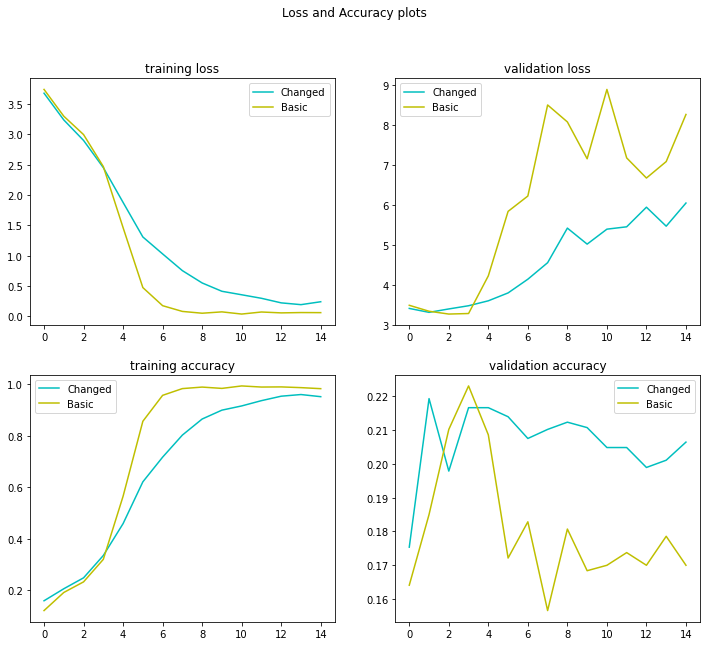

In [ ]:
plotter('bnorm')

## Adding New Layers

#### Adding new layers theoretically increases parameters and thus should translate in better approximation of the function , but due to being run for very less epochs the results are inconclusive. Although we can conclude that since there are more parameters they would take more number of epochs to converge to a minima.

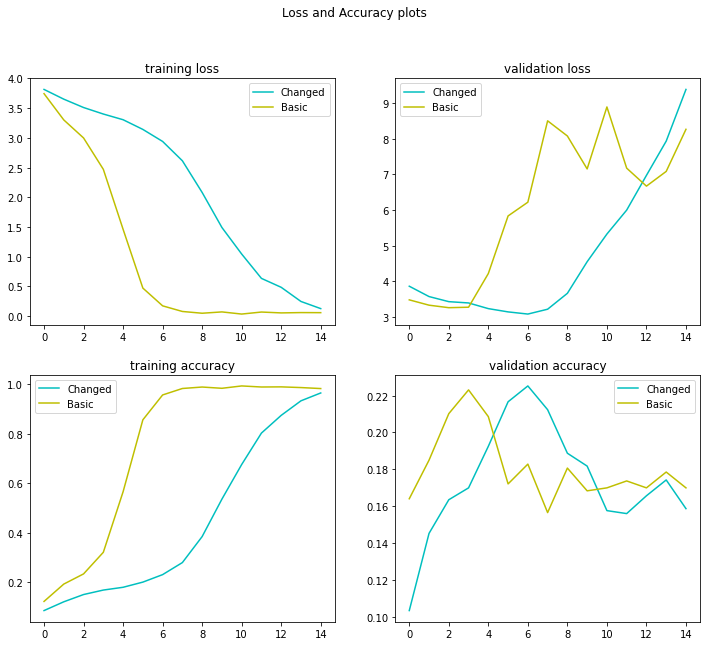

In [ ]:
plotter('nlayer')

## Dropout

#### We observe that dropout has helped in reducing the validation loss and prevented the network from overfitting. Large neural nets trained on relatively small datasets can overfit the training data.

#### With dropout (dropout rate less than some small value), the accuracy will gradually increase and loss will gradually decrease first(That is what is happening in our case).

####  The model learns the statistical noise in the training data, which results in poor performance when the model is evaluated on new data, e.g. a test dataset. Generalization error increases due to overfitting.





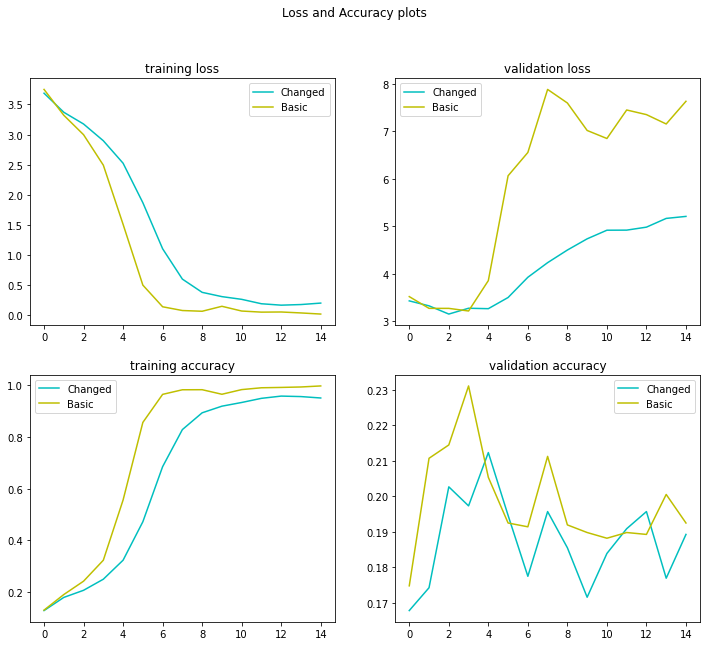

In [ ]:
plotter('dropout')

## Different Pooling Layers

#### We can see following things:
#### 1. The image size is reduced to its half: by taking groups of 2x2 pixels and only retaining the maximum, now the image is half bigger.
#### 2. The edges we kept when applying the convolution with the vertical edge filter not only are maintained, but are also intensified.


#### 3.A basic convolutional neural network can be seen as a sequence of convolution layers and pooling layers. When the image goes through them, the important features are kept in the convolution layers, and thanks to the pooling layers, these features are intensified and kept over the network, while discarding all the information that doesn’t make a difference for the task.

## MaxPool

#### Here we see that the training curves are almost the same.Only major change is the reduction of validation loss and increase in validation accuracy 

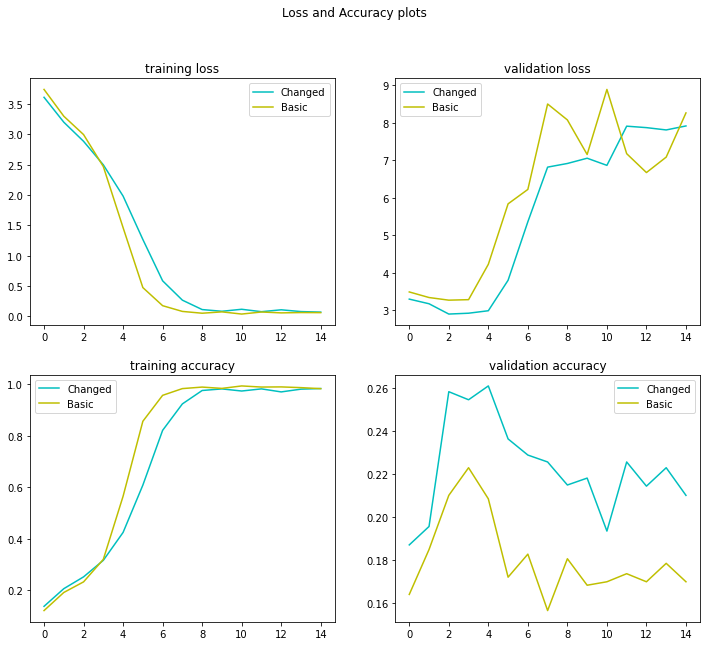

In [ ]:
plotter('maxpool')

## AvgPool

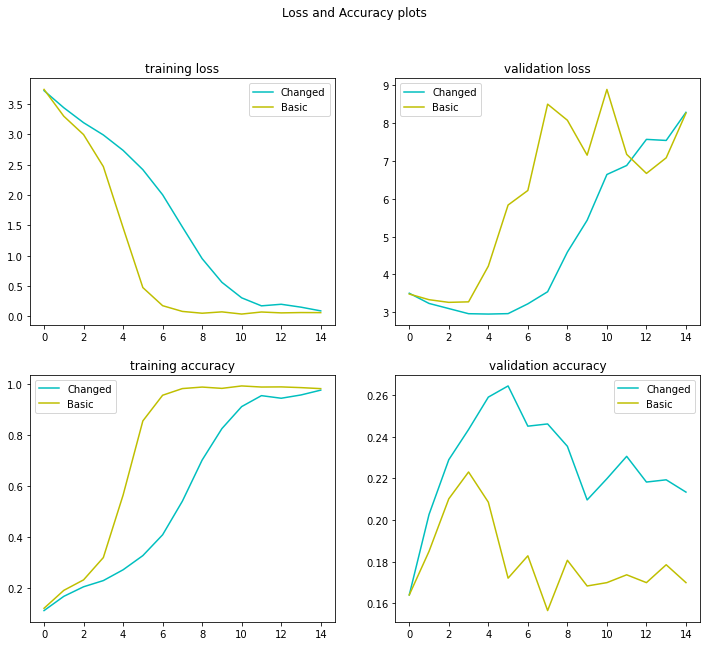

In [ ]:
plotter('avgpool')

## Different Optimizers

#### Adam is a gradient-based optimization algorithm, making use of the stochastic gradient extensions of AdaGrad and RMSProp, to deal with machine learning problems involving large datasets and high-dimensional parameter spaces. By combining the advantages of these extensions, Adam avoids issues such as with AdaGrad’s drastic diminishing in the learning rate from failing to scale the denominator.


####Adam uses both first order moment  mt  and 2nd order moment  gt  but they are both decayed over time. Step size is approximately  ±α  . Step size will decrease, as it approaches minimum.
Here we have used 2 different optimizers Adagrad and SGD.

### AdaGrad
#### Adagrad scales alpha for each parameter according to the history of gradients (previous steps) for that parameter which is basically done by dividing current gradient in update rule by the sum of previous gradients. As a result, what happens is that when the gradient is very large, alpha is reduced and vice-versa.

#### The reason behind the need for different learning rates is that the learning rate for sparse features parameters needs to be higher compare to the dense features parameter because the frequency of occurrence of sparse features is lower.


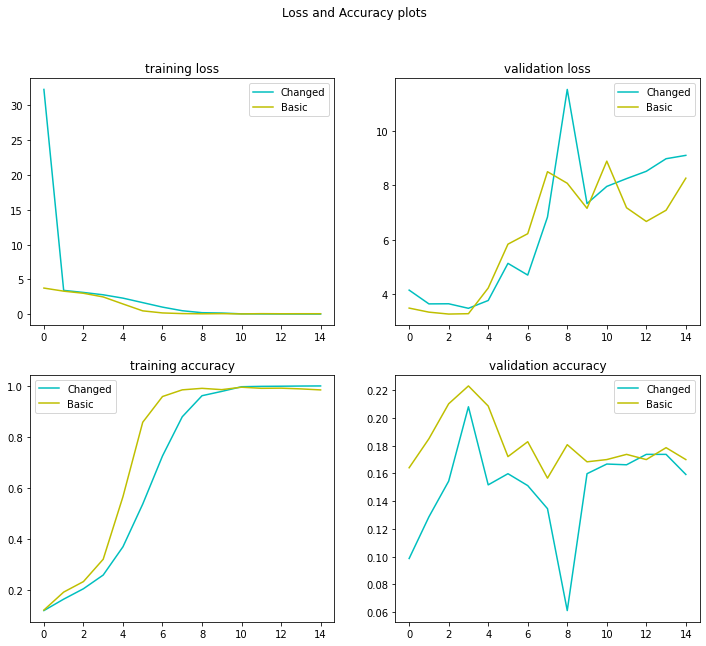

In [ ]:
plotter('adagrad')

## SGD 
#### Stochastic gradient descent (SGD) in contrast performs a parameter update for each training example

#### Batch gradient descent performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update. SGD does away with this redundancy by performing one update at a time. It is therefore usually much faster and can also be used to learn online.
#### SGD performs frequent updates with a high variance that cause the objective function to fluctuate heavily

#### While batch gradient descent converges to the minimum of the basin the parameters are placed in, SGD's fluctuation, on the one hand, enables it to jump to new and potentially better local minima. On the other hand, this ultimately complicates convergence to the exact minimum, as SGD will keep overshooting.

### Drawbacks:
#### Choosing a proper learning rate can be difficult.Additionally, the same learning rate applies to all parameter updates. Another key challenge of minimizing highly non-convex error functions common for neural networks is avoiding getting trapped in their numerous suboptimal local minima.

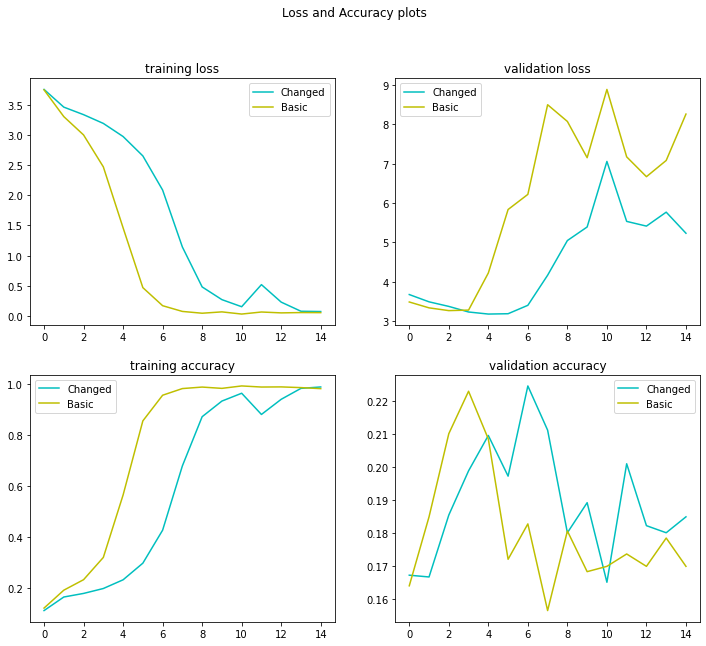

In [20]:
plotter('sgd')

## Data augmentation

#### Data Augmentation is very important to regularize your network and increase the size of your training set. There are many Data transformation techniques (rotation, flip, crop, etc…) that can change the images’ pixel values but still keep almost the whole information of the image, so that human could hardly tell whether it was augmented or not. This forces the model to be more flexible with the large variation of object inside the image, regarding less on position, orientation, size, color,…Models trained with data augmentation usually generalize better

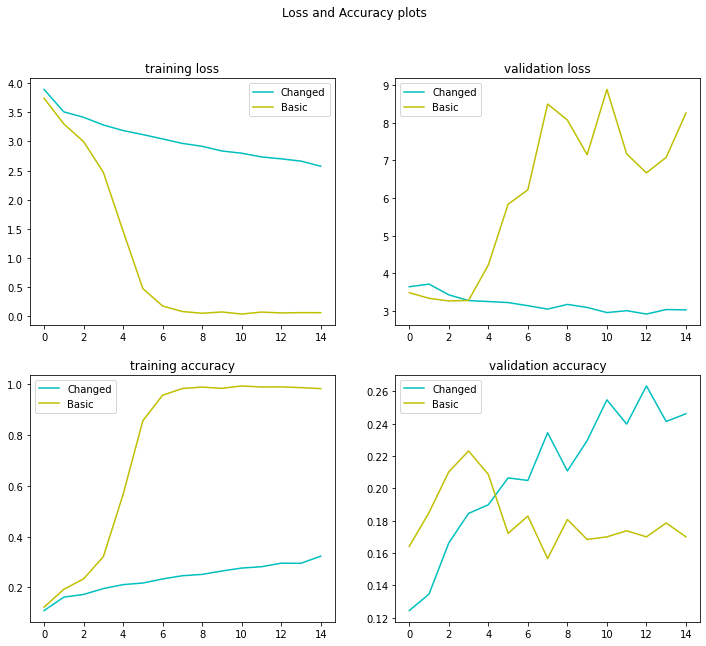

In [16]:
plotter('dataaug')

## BONUS: Residual Blocks

#### In this implementation of a basic residual block we have only one block with a skip connection , We don't see much value of the residual blocks in here because the network is shallow and consists of very less parameters . Thus the results obtained are not accurate. 

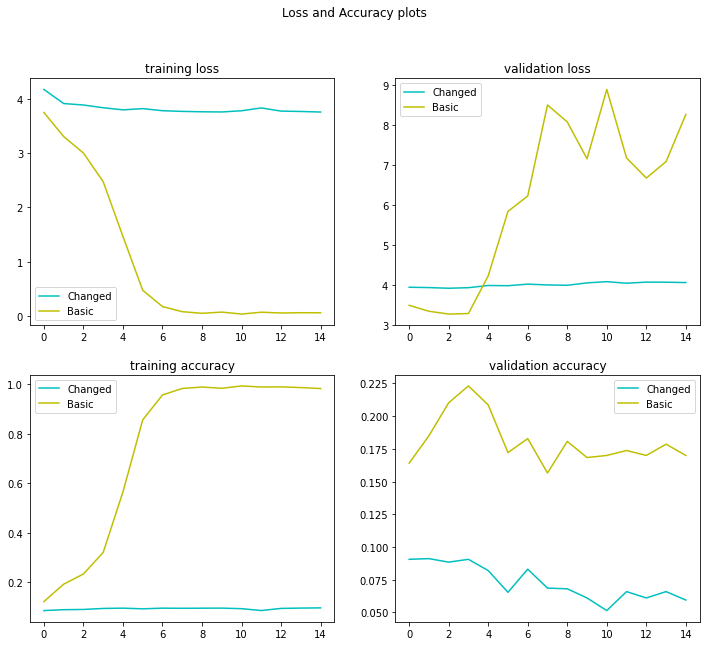

In [18]:
plotter('resblock')

## BONUS: Different learning techniques

## transfer learning

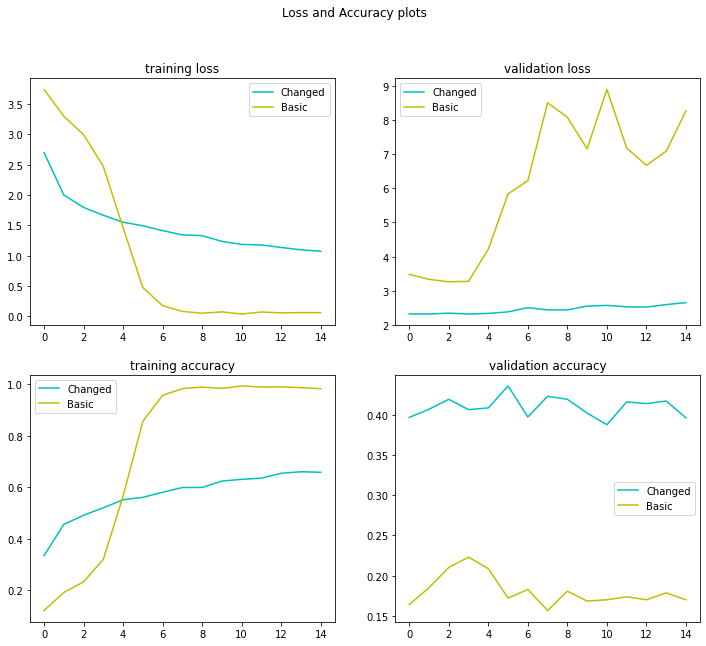

In [31]:
plotter('transfer')